### Init Config

In [840]:
# from google.colab import drive
# drive.mount('/content/drive')

In [841]:
import numpy as np
import pandas as pd
import re
import math
from collections import Counter
import nltk
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.datasets import make_regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.multioutput import RegressorChain
from sklearn.svm import LinearSVR, SVR
from sklearn.metrics import auc
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
import warnings

from wordfreq import zipf_frequency
from wordfreq import word_frequency

warnings.filterwarnings("ignore")

In [842]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Colab Notebooks

In [843]:
df = pd.read_excel("Problem_C_Data_Wordle.xlsx")
df.head(3)

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,...,f5,f6,f7,f8,f9,f10,567_tries,23_tries,sum,56_tries
0,2022-12-31,560,manly,20380,1899,0,2,17,37,29,...,2,3.66,1,4.570000e-06,0.183242,4.570,43,19,99,41
1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,...,2,2.99,1,9.770000e-07,0.182600,0.977,36,25,99,35
2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,...,2,3.50,1,3.160000e-06,0.182990,3.160,44,18,100,42


### tmp

In [844]:
oneTry = df['1 try']
twoTry = df['2 tries']
threeTry = df['3 tries']
fourTry = df['4 tries']
fiveTry = df['5 tries']
sixTry = df['6 tries']
sevenTry = df['7 or more tries (X)']
sumTry=df['sum']

In [845]:
fulltry_lst = np.array([oneTry, twoTry, threeTry, fourTry, fiveTry, sixTry, sevenTry])
fulltry_dist = (np.array(fulltry_lst) / np.array(sumTry)).T * 100
# try_lst = np.array([twoTry,threeTry,fourTry,fiveTry,sixTry,sevenTry])
# try_lst = np.array([twoTry,threeTry,fourTry,fiveTry,sixTry])
# try_lst = np.array([twoTry,threeTry,fiveTry,sixTry])
# col_0 = try_lst[:, 0]
# try_dist = []
# for i in range(len(df)):
#   try_dist.append(try_lst[:, i])
try_dist = np.concatenate((fulltry_dist[:, 1:3], fulltry_dist[:, 4:6]), axis=1)
# try_dist

In [846]:
file = open("valid-wordle-words.txt")
words = file.read().split()
# words = df["Word"]
df = pd.read_excel("Problem_C_Data_Wordle.xlsx")
subwords = df["Word"]
avgscores = df["avg_score"]
fullscores = df[
    [
        "1 try",
        "2 tries",
        "3 tries",
        "4 tries",
        "5 tries",
        "6 tries",
        "7 or more tries (X)",
    ]
]

CZERO = ord("a")

In [847]:
wordfreq = np.asarray(
    [word_frequency(words[i], "en") for i in range(len(words))], dtype=np.float64
)
maxfreq = max(wordfreq)
wordfreq = wordfreq / maxfreq
wordfreq = 1 / (1 + np.exp(-(wordfreq - 0.5) * 3))

avgscores = np.asarray(avgscores) - min(avgscores)
avgscores = avgscores / max(avgscores)

fullscores = np.asarray(fullscores)
fullscores = fullscores.T / (np.sum(fullscores, axis=1))
fullscores = fullscores.T
fullscores=fullscores[:,2:]
fullscores.shape

(358, 5)

In [848]:
charpos = np.zeros((26, 6))
for i in range(len(words)):
    for j in range(5):
        charpos[ord(words[i][j]) - CZERO][j] += wordfreq[i]
        charpos[ord(words[i][j]) - CZERO][5] += wordfreq[i]

In [849]:
charcombo = np.zeros((26, 26))
for i in range(len(words)):
    for j in range(4):
        a = ord(words[i][j]) - ord("a")
        b = ord(words[i][j + 1]) - ord("a")
        charcombo[a][b] += wordfreq[i]

In [850]:
count = 0
charcomboele = [(i, j, charcombo[i][j]) for i in range(26) for j in range(26)]
charcomboord = np.zeros((26, 26))
charcomboele = sorted(charcomboele, key=lambda e: e[2])
for i in range(26 * 26):
    a = charcomboele[i][0]
    b = charcomboele[i][1]
    c = charcomboele[i][2]
    charcomboord[a][b] = count
    if i < 26 * 26 - 1:
        if c != charcomboele[i + 1][2]:
            count += 1

In [851]:
charnumber = np.zeros(len(words))
count = 0
for i in range(len(words)):
    count = 0
    word = words[i]
    for j in range(5):
        same = False
        for k in range(j):
            if word[k] == word[j]:
                same = True
                break
        if not same:
            count += 1
    charnumber[i] = count

In [852]:
def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiou"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

In [853]:
def getfeaturefq(word):
    # charnumber
    f0 = 0
    for j in range(5):
        same = False
        for k in range(j):
            if word[k] == word[j]:
                same = True
                break
        if not same:
            f0 += 1
    dummy = np.zeros((5))
    dummy[f0 - 1] = 1

    # charfeq
    f1 = 0
    for i in range(5):
        f1 += charpos[ord(word[i]) - ord("a")][5]
    f1 /= np.sum(charpos[:, -1])

    # charpos
    f2 = 0
    for i in range(5):
        f2 += charpos[ord(word[i]) - ord("a")][i]
    f2 /= np.sum(charpos[:, 0]) * 5

    # charcombo
    f3 = 0
    for i in range(4):
        a = ord(word[i]) - ord("a")
        b = ord(word[i + 1]) - ord("a")
        f3 += charcombo[a][b]
    f3 /= np.sum(charcombo)

    f4 = syllable_count(word)

    f5 = zipf_frequency(word, "en")
    f6 = word_frequency(word, "en")

    lo = 0
    hi = len(words) - 1
    while hi > lo:
        mid = (lo + hi) // 2
        if words[mid] < word:
            lo = mid + 1
        else:
            hi = mid
    f7 = wordfreq[lo]

    return np.concatenate((dummy, np.asarray([f1, f2, f3, f4, f5, f6, f7])), axis=0)
    # return np.asarray([f1])

In [854]:
featureList = []
for word in subwords:
    featureList.append(getfeaturefq(word))
len(featureList)

358

In [855]:
features = [getfeaturefq(word) for word in subwords]
target = avgscores
# target = fullscores

### Add word feature

In [856]:
def find_max_rep(w):
    return Counter(list(w)).most_common()[0][1]

In [857]:
subwords = df["Word"]
f = pd.DataFrame(subwords.apply(find_max_rep))
f.to_excel("./feature.xlsx")

### Classifier

In [858]:
y = df["7 or more tries (X)"]
cols_features = ["f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10"]
x = df[cols_features]
for i in range(x.shape[1]):
    print(f"F{i+1}: {np.corrcoef(y, x.iloc[:, i])[0][1]}")

F1: -0.1931209244665335
F2: -0.07910608687349653
F3: 0.2286276559754378
F4: 0.0511294148546902
F5: 0.030122143094830887
F6: -0.1548685949307712
F7: 0.20525632659366153
F8: -0.0455451658169513
F9: -0.04804828714440037
F10: -0.04554516581695132


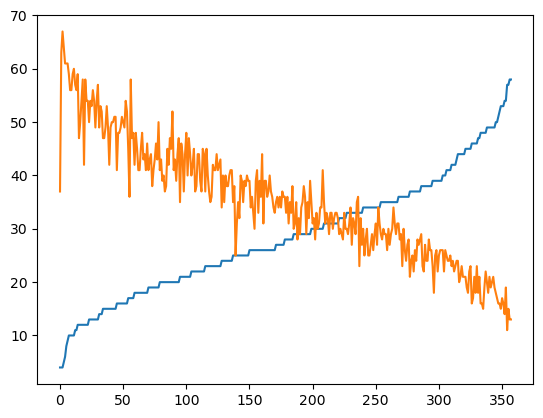

In [859]:
pairs=[(np.array(df['23_tries'])[i],np.array(df['56_tries'])[i],np.array(df['7 or more tries (X)'][i])) for i in range(len(subwords))]
pairs=np.asarray(sorted(pairs,key=lambda e:e[0])).T
plt.plot(np.arange(len(subwords)),pairs[0],pairs[1])


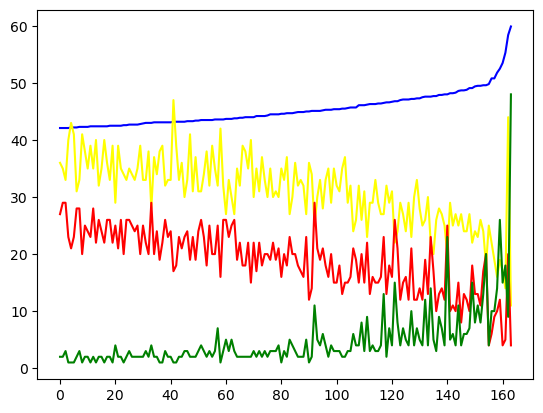

In [860]:
pairs=[(np.array(df['avg_score'])[i],np.array(df['4 tries'])[i],np.array(df['23_tries'][i]),np.array(df['7 or more tries (X)'])[i],) for i in range(len(subwords)) if np.array(df['avg_score'][i])>4.2]
pairs=np.asarray(sorted(pairs,key=lambda e:e[0])).T
plt.plot(np.arange(len(pairs[0])),pairs[0]*10,c='blue')
plt.plot(np.arange(len(pairs[0])),pairs[1],c='yellow')
plt.plot(np.arange(len(pairs[0])),pairs[2],c='red')
plt.plot(np.arange(len(pairs[0])),pairs[3],c='green')

plt.show()

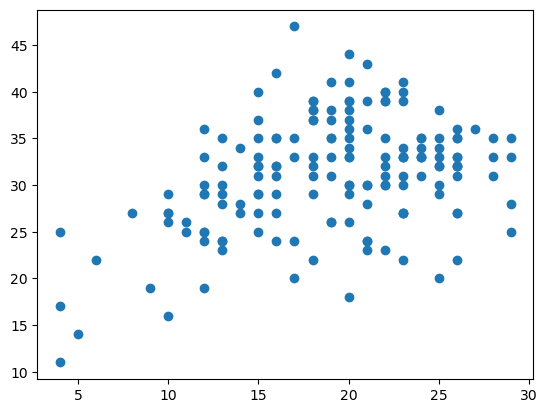

In [861]:
plt.scatter(pairs[2],pairs[1])

In [862]:
cols_features = ["f7","f2","f3","f4","f10"]
try7_threshold = 10
x = df[cols_features]


y_raw = df["7 or more tries (X)"]
y = np.array(np.where(y_raw < try7_threshold, 0, 1))
idx0 = []
idx1 = []
for i in range(len(y)):
    if y[i]:
        idx1.append(i)
    else:
        idx0.append(i)
x0 = x.iloc[
    idx0,
]
x1 = x.iloc[
    idx1,
]
y0 = pd.DataFrame(np.where(y_raw < try7_threshold, 0, 1)).iloc[
    idx0,
]
y1 = pd.DataFrame(np.where(y_raw < try7_threshold, 0, 1)).iloc[
    idx1,
]


x1 = pd.concat([x1, x1, x1, x1, x1, x1, x1, x1, x1], axis=0)
y1 = pd.concat([y1, y1, y1, y1, y1, y1, y1, y1, y1], axis=0)
x1 = pd.concat([x1, x1])
y1 = pd.concat([y1, y1])
print(len(x0))
print(len(x1))


train0, test0, trainy0, testy0 = train_test_split(
    x0, y0, test_size=0.25, random_state=257248
)
train1, test1, trainy1, testy1 = train_test_split(
    x1, y1, test_size=0.25, random_state=257248
)
train = pd.concat([train0, train1], axis=0)
test = pd.concat([test0, test1], axis=0)
trainy = pd.concat([trainy0, trainy1], axis=0)
testy = pd.concat([testy0, testy1], axis=0)


pd.concat([train, trainy], axis=1)


cls = LogisticRegression()
cls.fit(train, trainy)
print(f"Train accuracy: {cls.score(train, trainy)}")
cls.predict(train)
cls.score(test, testy)

339
342
Train accuracy: 0.6372549019607843


0.6081871345029239

In [863]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def evaluate(rf, train, valid, test, train_y, valid_y, return_pred=False, version=1, return_auc=False):
    if version == 2:
        rf_train_y = rf.predict(train)
        rf_valid_y = rf.predict(valid)
        pred = rf.predict(test)
        acr_train = rf.score(train, train_y)
        acr_valid = rf.score(valid, valid_y)
        print(f"Train Accuracy: {acr_train:.4f}; Validation Accuracy: {acr_valid:.4f}; Test: {np.sum(pred):>4d}")
        cm = confusion_matrix(train_y, rf_train_y)
        tn, fp, fn, tp = cm.ravel()
        print(f"Train AUROC: {roc_auc_score(train_y, rf_train_y):.4f}; FP: {fp:>4d}; FN: {fn:>4d}")
        cm = confusion_matrix(valid_y, rf_valid_y)
        tn, fp, fn, tp = cm.ravel()
        print(f"Valid AUROC: {roc_auc_score(valid_y, rf_valid_y):.4f}; FP: {fp:>4d}; FN: {fn:>4d}")
        print()
    # elif version == 3:
    #     pred_train = rf.predict(train)
    #     pred_valid = rf.predict(valid)
    #     pred = rf.predict(test)
    #     print(f"Train RMSE: {mse(train_y, pred_train, squared=False):.4f}")
    #     print(f"Valid RMSE: {mse(valid_y, pred_valid, squared=False):.4f}")
    else:
        rf_train_y = rf.predict_proba(train)[:,1]
        rf_valid_y = rf.predict_proba(valid)[:,1]
        pred = rf.predict_proba(test)[:,1]
        acr_train = rf.score(train, train_y)
        acr_valid = rf.score(valid, valid_y)
        print(f"Train Accuracy: {acr_train:.4f}; Validation Accuracy: {acr_valid:.4f}")
        auc_train = roc_auc_score(train_y, rf_train_y)
        auc_valid = roc_auc_score(valid_y, rf_valid_y)
        print(f"Train AUROC: {auc_train:.4f}")
        print(f"Valid AUROC: {auc_valid:.4f}")
    if return_pred and return_auc and version == 1:
        return pred, auc_train, auc_valid
    elif return_pred:
        return pred
    else:
        return

In [864]:
for i in range(1):
# for i in [0,1e-1,1,10,100,1000]: # gamma
# for i in range(1,101,10): # min_child_weight
# for i in [1,2,3,4,5,6,7,8]: # max_depth
# for i in [.1, .5, 1, 2, 3, 5, 8, 10, 15]: # scale_pos_weight
    print(f">>>{i}<<<")
    xgb = XGBClassifier(
        random_state = 257248,
        n_estimators = 1000,
        scale_pos_weight = 1,
        max_depth = 6,
        # learning_rate = 0.1,
        eval_metric = ["auc"],
        # early_stopping_rounds = 15,
        # subsample = 0.8,
        # colsample_bytree = 0.75,
        # min_child_weight = 10,
        # reg_alpha = i,
        # reg_lambda = 100,
        # gamma = 1,
    )

    # es = callback.EarlyStopping(
    #     rounds=10,
    #     abs_tol=1e-3,
    #     save_best=True,
    #     maximize=True,
    #     data_name="validation_0",
    #     metric_name="auc",
    # )

    final_gb = xgb.fit(train, trainy, eval_set=[(train, trainy), (test, testy)], verbose=True, early_stopping_rounds=15)
    pred_test = evaluate(xgb, train, test, test, trainy, testy, return_pred=True, version=1)

>>>0<<<
[0]	validation_0-auc:0.97371	validation_1-auc:0.98174
[1]	validation_0-auc:0.98847	validation_1-auc:0.99083
[2]	validation_0-auc:0.99496	validation_1-auc:0.99008
[3]	validation_0-auc:0.99828	validation_1-auc:1.00000
[4]	validation_0-auc:0.99777	validation_1-auc:0.99932
[5]	validation_0-auc:0.99932	validation_1-auc:0.99932
[6]	validation_0-auc:0.99968	validation_1-auc:1.00000
[7]	validation_0-auc:0.99968	validation_1-auc:0.99932
[8]	validation_0-auc:1.00000	validation_1-auc:0.99932
[9]	validation_0-auc:1.00000	validation_1-auc:1.00000
[10]	validation_0-auc:1.00000	validation_1-auc:1.00000
[11]	validation_0-auc:1.00000	validation_1-auc:1.00000
[12]	validation_0-auc:1.00000	validation_1-auc:1.00000
[13]	validation_0-auc:1.00000	validation_1-auc:1.00000
[14]	validation_0-auc:1.00000	validation_1-auc:1.00000
[15]	validation_0-auc:1.00000	validation_1-auc:1.00000
[16]	validation_0-auc:1.00000	validation_1-auc:1.00000
[17]	validation_0-auc:1.00000	validation_1-auc:1.00000
Train Accura

In [865]:
pred_test

array([0.27836236, 0.16015123, 0.14681184, 0.14302818, 0.14509329,
       0.7001775 , 0.167261  , 0.45612168, 0.1487293 , 0.14509329,
       0.14509329, 0.1487293 , 0.14302818, 0.3888902 , 0.17373224,
       0.14509329, 0.14302818, 0.16015123, 0.14302818, 0.16015123,
       0.14302818, 0.31654176, 0.14509329, 0.16015123, 0.6735345 ,
       0.14509329, 0.14302818, 0.15752317, 0.14509329, 0.44359615,
       0.14509329, 0.3981039 , 0.14302818, 0.14302818, 0.15752317,
       0.15752317, 0.16015123, 0.31654176, 0.14302818, 0.15752317,
       0.14302818, 0.5880155 , 0.14509329, 0.14302818, 0.16015123,
       0.14302818, 0.16015123, 0.167261  , 0.14681184, 0.14302818,
       0.14681184, 0.14302818, 0.58858734, 0.14509329, 0.16015123,
       0.16015123, 0.16015123, 0.14302818, 0.14302818, 0.15752317,
       0.14302818, 0.14509329, 0.14302818, 0.1487293 , 0.16372122,
       0.16015123, 0.14302818, 0.14509329, 0.16015123, 0.14302818,
       0.41747203, 0.6054697 , 0.14302818, 0.18199928, 0.15752

### Clustering

In [866]:
# cols_features = ["f7", "f10", "7 or more tries (X)"]
cols_features = ["f1", "f3", "f7", "7 or more tries (X)"]
dataset = df[cols_features]
# dataset["f10"] = dataset["f10"] * 10000
# dataset["f7"] = dataset["f7"] ** 2
dataset["f3"] = dataset["f3"] * 100

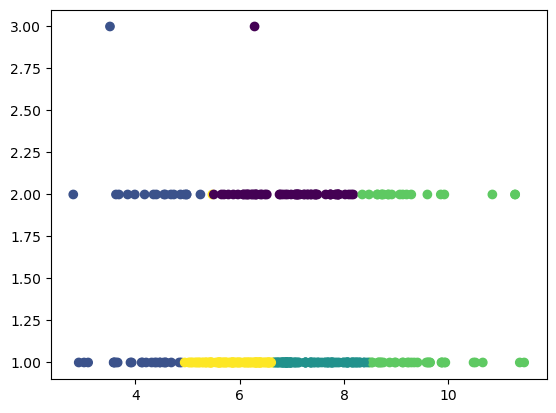

In [867]:
x = list(dataset["f7"])
y = list(dataset["f3"])
z = list(dataset["f1"])

data = list(zip(x, y, z))

kmeans = KMeans(n_clusters=5, random_state=257248)
kmeans.fit(data)

plt.scatter(y, x, c=kmeans.labels_)
plt.show()

In [868]:
cluster = list(kmeans.labels_)
idx = [[],[],[],[],[]]
for i in range(len(cluster)):
    idx[cluster[i]].append(i)

In [869]:
for c in idx:
    print(list(dataset.iloc[c,-1]))

[3, 1, 1, 0, 3, 1, 0, 2, 3, 18, 23, 0, 11, 1, 2, 0, 2, 13, 7, 4, 1, 1, 5, 15, 1, 13, 2, 15, 2, 2, 3, 1, 2, 3, 1, 4, 1, 2, 1, 1, 1, 2, 3, 4, 1, 3, 3, 8, 4, 2, 2, 2, 4, 3, 10, 7, 2, 5, 3, 1, 3]
[1, 1, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 4, 1, 1, 1, 2, 1, 7, 4, 9, 2, 1, 1, 1, 1, 1, 9, 3, 3, 2, 1, 2, 2, 4]
[1, 0, 3, 0, 1, 0, 2, 0, 2, 1, 1, 5, 4, 2, 3, 1, 0, 1, 1, 4, 0, 3, 1, 2, 3, 0, 2, 11, 0, 0, 3, 5, 0, 8, 0, 1, 7, 2, 0, 2, 2, 8, 0, 1, 3, 1, 1, 1, 10, 1, 2, 1, 3, 0, 2, 2, 2, 1, 1, 1, 0, 2, 7, 1, 0, 2, 5, 1, 1, 1, 4, 1, 6, 14, 2, 3, 1, 1, 1, 3, 1, 2, 1, 2, 8, 9, 3, 1, 3, 4, 1, 1, 1, 4, 1, 1, 3, 2, 1, 4]
[2, 1, 3, 1, 3, 4, 10, 1, 1, 1, 2, 3, 1, 11, 2, 1, 48, 4, 7, 3, 5, 5, 2, 1, 4, 2, 7, 1, 2, 5, 1, 6, 3, 1, 1, 4, 2, 12, 1, 26, 4, 6, 2, 1, 15, 1, 1, 1, 2, 2, 2, 1, 1, 5, 4]
[2, 1, 14, 2, 0, 0, 1, 3, 2, 3, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 2, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 6, 1, 1, 4, 2, 2, 1, 1,

### xx


In [870]:
import sklearn
print(sklearn.__version__)

1.2.0


In [871]:
from sklearn.ensemble import RandomForestRegressor

In [872]:
# linear regression for multioutput regression
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
# decision tree for multioutput regression
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
# create datasets
X = featureList
y = try_dist
# define model
model = DecisionTreeRegressor()
# fit model
model.fit(X, y)
# make a prediction
#row = [0.21947749, 0.32948997, 0.81560036, 0.440956, -0.0606303, -0.29257894, -0.2820059, -0.00290545, 0.96402263, 0.04992249]
#yhat = model.predict([row])
# summarize prediction
#print(yhat[0])

#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=2, random_state=1, noise=0.5)
# define model
#model = LinearRegression()
# fit model
#model.fit(X, y)
# make a prediction
#row = [0.21947749, 0.32948997, 0.81560036, 0.440956, -0.0606303, -0.29257894, -0.2820059, -0.00290545, 0.96402263, 0.04992249]
#yhat = model.predict([row])
# summarize prediction
#print(yhat[0])
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 5.493 (0.706)


In [873]:
prediction_lst1 = []

for i in range(len(subwords)):
  prediction_lst1.append(model.predict(np.array(getfeaturefq(subwords[i])).reshape(1,-1)))

#model.score(X,y)
for i in range(len(subwords)):
  print(subwords[i],"predicted:",prediction_lst1[i],"real value:",y[i])

manly predicted: [[ 2.02020202 17.17171717 29.29292929 12.12121212]] real value: [ 2.02020202 17.17171717 29.29292929 12.12121212]
molar predicted: [[ 4.04040404 21.21212121 26.26262626  9.09090909]] real value: [ 4.04040404 21.21212121 26.26262626  9.09090909]
havoc predicted: [[ 2. 16. 30. 12.]] real value: [ 2. 16. 30. 12.]
impel predicted: [[ 3.03030303 21.21212121 25.25252525  9.09090909]] real value: [ 3.03030303 21.21212121 25.25252525  9.09090909]
condo predicted: [[ 2. 17. 29. 14.]] real value: [ 2. 17. 29. 14.]
judge predicted: [[ 2.02020202  8.08080808 26.26262626 33.33333333]] real value: [ 2.02020202  8.08080808 26.26262626 33.33333333]
extra predicted: [[ 5. 20. 28. 10.]] real value: [ 5. 20. 28. 10.]
poise predicted: [[10.89108911 33.66336634 14.85148515  5.94059406]] real value: [10.89108911 33.66336634 14.85148515  5.94059406]
aorta predicted: [[ 6.93069307 25.74257426 19.8019802   9.9009901 ]] real value: [ 6.93069307 25.74257426 19.8019802   9.9009901 ]
excel predict

In [874]:
# define model
model = DecisionTreeRegressor()
# fit model
model.fit(X, y)
# make a prediction
#row = [0.21947749, 0.32948997, 0.81560036, 0.440956, -0.0606303, -0.29257894, -0.2820059, -0.00290545, 0.96402263, 0.04992249]
#yhat = model.predict([row])
# summarize prediction
#print(yhat[0])
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 5.437 (0.696)


In [875]:
prediction_lst3 = []

for i in range(len(subwords)):
  prediction_lst3.append(model.predict(np.array(getfeaturefq(subwords[i])).reshape(1,-1)))
  
#model.score(X,y)
for i in range(len(subwords)):
  print(subwords[i],"predicted:",prediction_lst3[i],"real value:",y[i])

manly predicted: [[ 2.02020202 17.17171717 29.29292929 12.12121212]] real value: [ 2.02020202 17.17171717 29.29292929 12.12121212]
molar predicted: [[ 4.04040404 21.21212121 26.26262626  9.09090909]] real value: [ 4.04040404 21.21212121 26.26262626  9.09090909]
havoc predicted: [[ 2. 16. 30. 12.]] real value: [ 2. 16. 30. 12.]
impel predicted: [[ 3.03030303 21.21212121 25.25252525  9.09090909]] real value: [ 3.03030303 21.21212121 25.25252525  9.09090909]
condo predicted: [[ 2. 17. 29. 14.]] real value: [ 2. 17. 29. 14.]
judge predicted: [[ 2.02020202  8.08080808 26.26262626 33.33333333]] real value: [ 2.02020202  8.08080808 26.26262626 33.33333333]
extra predicted: [[ 5. 20. 28. 10.]] real value: [ 5. 20. 28. 10.]
poise predicted: [[10.89108911 33.66336634 14.85148515  5.94059406]] real value: [10.89108911 33.66336634 14.85148515  5.94059406]
aorta predicted: [[ 6.93069307 25.74257426 19.8019802   9.9009901 ]] real value: [ 6.93069307 25.74257426 19.8019802   9.9009901 ]
excel predict

In [876]:
# define dataset
X = featureList
y = try_dist
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=2, random_state=1, noise=0.5)
# define base model
model = LinearSVR()
# define the chained multioutput wrapper model
wrapper = RegressorChain(model)
# fit the model on the whole dataset
wrapper.fit(X, y)
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(wrapper, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 4.207 (0.447)


In [877]:
prediction_lst2 = []

for i in range(len(subwords)):
  prediction_lst2.append(wrapper.predict(np.array(getfeaturefq(subwords[i])).reshape(1,-1)))

#model.score(X,y)
for i in range(len(subwords)):
  print(subwords[i],"predicted:",prediction_lst2[i],"real value:",y[i])

manly predicted: [[ 5.61644305 22.7335105  23.08919522  9.40090535]] real value: [ 2.02020202 17.17171717 29.29292929 12.12121212]
molar predicted: [[ 4.75517201 22.61672094 24.57599193 10.01321443]] real value: [ 4.04040404 21.21212121 26.26262626  9.09090909]
havoc predicted: [[ 4.7865763  22.90679176 24.21299769  9.55818884]] real value: [ 2. 16. 30. 12.]
impel predicted: [[ 3.99436858 21.17209058 25.20775643 10.56279014]] real value: [ 3.03030303 21.21212121 25.25252525  9.09090909]
condo predicted: [[ 2.30499366 17.2867934  28.39754284 13.28722542]] real value: [ 2. 17. 29. 14.]
judge predicted: [[ 6.56835531 24.8051192  21.89364878  8.17095905]] real value: [ 2.02020202  8.08080808 26.26262626 33.33333333]
extra predicted: [[ 6.62305252 26.42021848 22.59904757  8.0642708 ]] real value: [ 5. 20. 28. 10.]
poise predicted: [[ 5.66047111 22.51810258 23.47243979  9.87889453]] real value: [10.89108911 33.66336634 14.85148515  5.94059406]
aorta predicted: [[ 2.29457739 16.94228776 28.87

In [878]:
# define dataset
X = featureList
y = try_dist
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=2, random_state=1, noise=0.5)
# define base model
model = RandomForestRegressor(n_estimators=1000, max_depth=4, min_samples_split=10)
# define the chained multioutput wrapper model
wrapper = RegressorChain(model)
# fit the model on the whole dataset
wrapper.fit(X, y)
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(wrapper, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 4.043 (0.341)


In [879]:
prediction_lst4 = []

for i in range(len(subwords)):
  prediction_lst4.append(wrapper.predict(np.array(getfeaturefq(subwords[i])).reshape(1,-1)))

#model.score(X,y)
for i in range(len(subwords)):
  print(subwords[i],"predicted:",prediction_lst4[i],"real value:",y[i])

manly predicted: [[ 6.58728588 25.12899721 21.93978731  9.30006107]] real value: [ 2.02020202 17.17171717 29.29292929 12.12121212]
molar predicted: [[ 5.84146073 22.56620969 24.58409415 10.14381971]] real value: [ 4.04040404 21.21212121 26.26262626  9.09090909]
havoc predicted: [[ 3.82145372 21.56575696 25.24584236 10.12677253]] real value: [ 2. 16. 30. 12.]
impel predicted: [[ 5.22146232 25.55193516 22.00712744  9.28805109]] real value: [ 3.03030303 21.21212121 25.25252525  9.09090909]
condo predicted: [[ 2.89095531 18.24948    27.70798291 12.05533252]] real value: [ 2. 17. 29. 14.]
judge predicted: [[ 5.54109418 24.42298871 23.26902144  9.20025405]] real value: [ 2.02020202  8.08080808 26.26262626 33.33333333]
extra predicted: [[ 6.13477427 26.02118133 22.19551818  9.2939827 ]] real value: [ 5. 20. 28. 10.]
poise predicted: [[ 8.08004573 28.95381088 18.87792633  6.79755015]] real value: [10.89108911 33.66336634 14.85148515  5.94059406]
aorta predicted: [[ 4.28342943 21.28828715 25.10

In [880]:
featureList

[array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 2.51861680e-01, 9.21793658e-02, 2.08726939e-02,
        1.00000000e+00, 3.66000000e+00, 4.57000000e-06, 1.83241598e-01]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 3.07152717e-01, 8.30052231e-02, 3.15346897e-02,
        2.00000000e+00, 2.99000000e+00, 9.77000000e-07, 1.82599751e-01]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 2.30015185e-01, 5.86462975e-02, 1.20479564e-02,
        2.00000000e+00, 3.50000000e+00, 3.16000000e-06, 1.82989510e-01]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 2.74219730e-01, 5.42321413e-02, 1.83857751e-02,
        2.00000000e+00, 2.36000000e+00, 2.29000000e-07, 1.82466350e-01]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 2.51449507e-01, 7.45522254e-02, 

In [881]:
new_featureList = []
for i in range(len(featureList)):
    if i in idx0:
        new_featureList.append(featureList[i])
# new_featureList

new_try_dist = []
for i in range(len(try_dist)):
    if i in idx0:
        new_try_dist.append(try_dist[i])
# new_try_dist

### run!

In [882]:
# define dataset
X = featureList
# X = new_featureList
y = try_dist
# y = new_try_dist
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=2, random_state=1, noise=0.5)
# define base model
model = SVR()
# define the chained multioutput wrapper model
wrapper = RegressorChain(model)
# fit the model on the whole dataset
wrapper.fit(X, y)
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(wrapper, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 4.181 (0.455)


In [883]:
prediction_lst5 = []

for i in range(len(subwords)):
# for i in idx0:
  prediction_lst5.append(wrapper.predict(np.array(getfeaturefq(subwords[i])).reshape(1,-1)))

#model.score(X,y)
# for i in range(len(words)):
for i in range(len(prediction_lst5)):
  print(subwords[i],"predicted:",prediction_lst5[i],"real value:",y[i])

manly predicted: [[ 5.68425065 24.35513927 23.17530005  9.78084804]] real value: [ 2.02020202 17.17171717 29.29292929 12.12121212]
molar predicted: [[ 4.43443461 21.32931951 25.67878282 11.93877093]] real value: [ 4.04040404 21.21212121 26.26262626  9.09090909]
havoc predicted: [[ 4.85325927 22.38107503 24.86345442 11.17597745]] real value: [ 2. 16. 30. 12.]
impel predicted: [[ 3.88798266 20.01979073 26.64767735 12.89303706]] real value: [ 3.03030303 21.21212121 25.25252525  9.09090909]
condo predicted: [[ 2.5741661  16.59613717 28.90265952 15.3779706 ]] real value: [ 2. 17. 29. 14.]
judge predicted: [[ 6.87872766 26.87670425 21.02302704  8.12927258]] real value: [ 2.02020202  8.08080808 26.26262626 33.33333333]
extra predicted: [[ 6.31030367 25.75404809 22.06723649  8.84819206]] real value: [ 5. 20. 28. 10.]
poise predicted: [[ 5.1150873  22.9803222  24.29975941 10.7463103 ]] real value: [10.89108911 33.66336634 14.85148515  5.94059406]
aorta predicted: [[ 2.12244785 15.60644381 29.43

0.4962215122501331


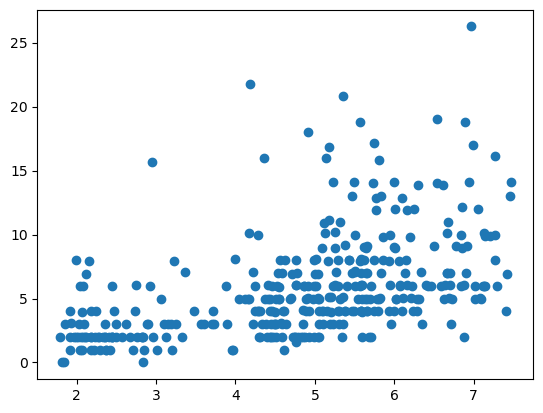

0.49100037758155457


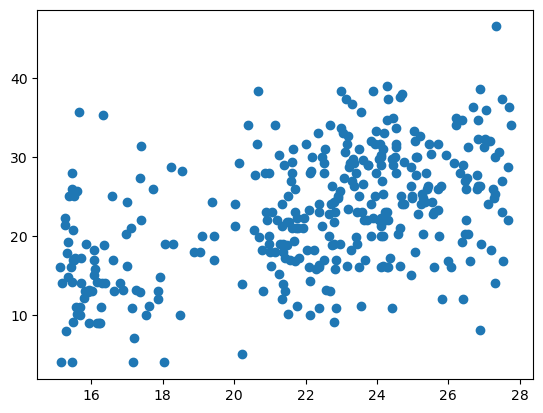

0.49045114814962687


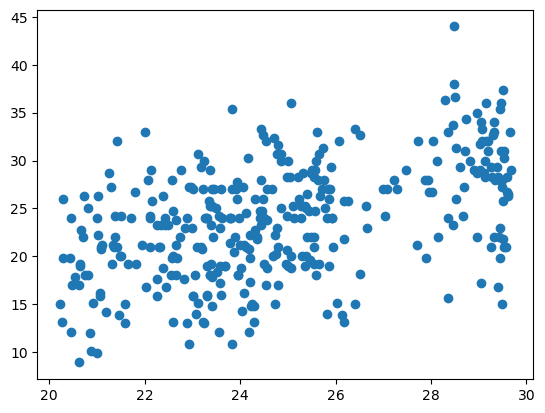

0.37946869793985405


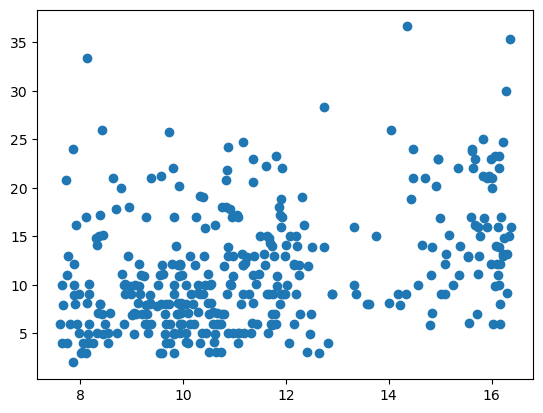

In [884]:
for i in range(4):
    plt.scatter(np.array(prediction_lst5)[:, 0, i], np.array(y)[:, i])
    print(np.corrcoef(np.array(prediction_lst5)[:, 0, i], np.array(y)[:, i])[0][1])
    plt.show()

In [885]:
np.corrcoef(threeTry, sevenTry)[0][1]

-0.5142618589878722

In [886]:
from sklearn.linear_model import LinearRegression
import numpy as np

# x1 = np.log(np.array(fourTry).reshape(-1,1))
# x2 = np.array(fourTry).reshape(-1,1)
# x3 = np.array(1/(fourTry-6.75)).reshape(-1,1)
# x4 = np.array(fourTry**2).reshape(-1,1)
easypart = np.asarray(
    [
        (
            fulltry_dist[i][1] + fulltry_dist[i][2],
            fulltry_dist[i][4] + fulltry_dist[1][5],
            fulltry_dist[i][3],
        )
        for i in range(len(subwords))
        if fulltry_dist[i][1] + fulltry_dist[i][2] >= 30
    ]
)
hardpart = np.asarray(
    [
        (
            fulltry_dist[i][1] + fulltry_dist[i][2],
            fulltry_dist[i][4] + fulltry_dist[i][5],
            fulltry_dist[i][3],
        )
        for i in range(len(subwords))
        if fulltry_dist[i][1] + fulltry_dist[i][2] <= 20
    ]
)
hardpart = hardpart.T
easypart = easypart.T

# Create some example data
# X = np.log(np.array(fourTry).reshape(-1,1))
# X = np.array([x1,x2,x3,x4]).reshape(-1,4)
X = hardpart[0].T.reshape(-1,1)
X2 = easypart[0:2].T
y = hardpart[2].reshape(-1, 1)
y2 = easypart[2].reshape(-1, 1)

# Create a linear regression object
reg = LinearRegression()
reg2 = LinearRegression()

# reg = SVR()
# Fit the linear regression model
reg.fit(X, y)
reg2.fit(X2, y2)

# Make a prediction for a new input value
# new_x = np.array([6]).reshape(-1, 1)
# prediction = reg.predict(new_x)
print(reg.score(X, y))
print(reg2.score(X2, y2))
k = reg.coef_               # 0.97942356
k2 = reg2.coef_             # -1.01707625 -1.55883301
# k1 = reg.coef_[0][1]
# k2 = reg.coef_[0][2]
# k3 = reg.coef_[0][3]
b = reg.intercept_          # 15.44568885
b2 = reg2.intercept_        # 116.31233276
print(reg.coef_)
print(reg2.coef_)
print(reg.intercept_)
print(reg2.intercept_)
# print(prediction)  # Output: [[7.]]

0.34316395694936386
0.4210060630548563
[[0.97942356]]
[[-1.01707625 -1.55883301]]
[15.44568885]
[116.31233276]


In [887]:
middlepart = np.asarray(
    [
        (
            fulltry_dist[i][1] + fulltry_dist[i][2],
            fulltry_dist[i][4] + fulltry_dist[1][5],
            fulltry_dist[i][3],
        )
        for i in range(len(subwords))
        if fulltry_dist[i][1] + fulltry_dist[i][2] < 30 and fulltry_dist[i][1] + fulltry_dist[i][2] >20
    ]
)
middlemean=np.sum(middlepart[:,2])/len(middlepart[:,2])
middlemean

34.21147628611258

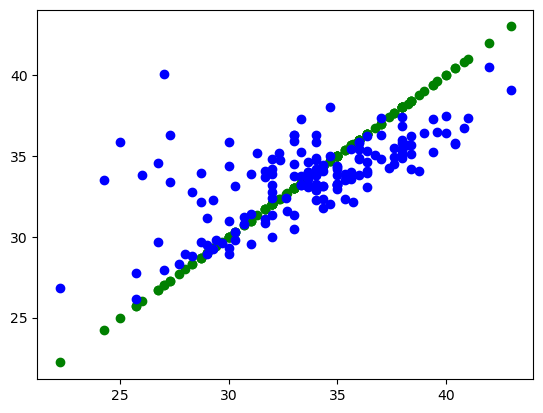

In [888]:
plt.scatter(y2,y2,c='green')
plt.scatter(y2,reg2.predict(X2),c='blue')

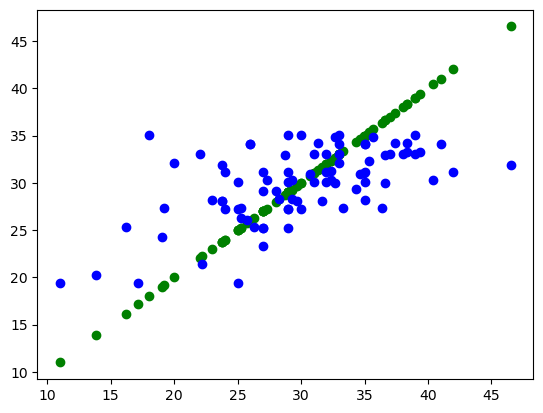

In [889]:
plt.scatter(y,y,c='green')
plt.scatter(y,reg.predict(X),c='blue')

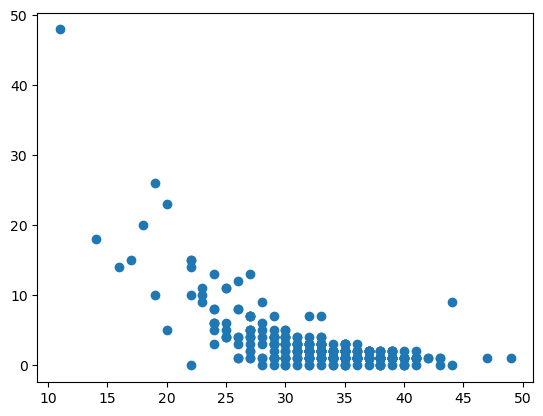

In [890]:
plt.scatter(fourTry,sevenTry)
plt.show()

In [891]:
import math


def func1(A, b, k):
    return (A - b + math.sqrt((A - b) ** 2 - 4 * k)) / 2 + 6.75


def func2(A, b, k):
    return b + (k / func1(A, b, k))


def func3(try23, try56):
    if try23 >= 30:
        # return (-1.01707625 * try23) + (-1.55883301 * try56) + 116.31233276
        return np.sum(reg2.coef_[0]*np.asarray([try23,try56]))+reg2.intercept_
    elif try23 <=20:
        # return 0.97942356 * try23 + 15.44568885
        return reg.coef_[0][0]*try23+reg.intercept_
    else:
        return middlemean


def avgtry(dist):
    total = 0
    for i in range(len(dist)):
        total += (i + 1) * dist[i] / 100
    return total

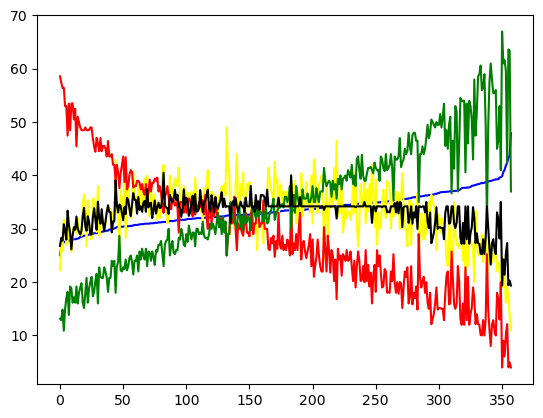

In [892]:
pairs = [
    (
        avgtry(fulltry_dist[i]),
        fulltry_dist[i][3],
        fulltry_dist[i][1] + fulltry_dist[i][2],
        fulltry_dist[i][4] + fulltry_dist[i][5],
        func3(fulltry_dist[i][1] + fulltry_dist[i][2],fulltry_dist[i][4] + fulltry_dist[1][5],),
    )
    for i in range(len(subwords))
]
pairs = np.asarray(sorted(pairs, key=lambda e: e[0])).T
plt.plot(np.arange(len(pairs[0])), pairs[0] * 8, c="blue")
plt.plot(np.arange(len(pairs[0])), pairs[1], c="yellow")
plt.plot(np.arange(len(pairs[0])), pairs[2], c="red")
plt.plot(np.arange(len(pairs[0])), pairs[3], c="green")
plt.plot(np.arange(len(pairs[0])), pairs[4], c="black")

plt.show()

In [893]:
l = []
fourandseven=[]
for i in range(len(prediction_lst5)):
    A = 100-prediction_lst5[i][0][0]-prediction_lst5[i][0][1]-prediction_lst5[i][0][2]-prediction_lst5[i][0][3]-0.472067039
    fourandseven.append(A)
    l.append(func1(A,b,k))

    #l.append(func((A-b)/(1+k)))
    #l.append(reg.predict(i[]))
    #l.append(reg.predict(np.array(fourTry[i]).reshape(-1,1)))
l = np.array(l).reshape(1,-1)

In [894]:
sevenTryPred = l
np.corrcoef(np.array(sevenTry).reshape(1,-1), sevenTryPred)


array([[ 1.        , -0.04728875],
       [-0.04728875,  1.        ]])

In [895]:
np.corrcoef(fourTry,sevenTry)
#np.corrcoef(oneTry,sevenTry)

array([[ 1.        , -0.66386077],
       [-0.66386077,  1.        ]])

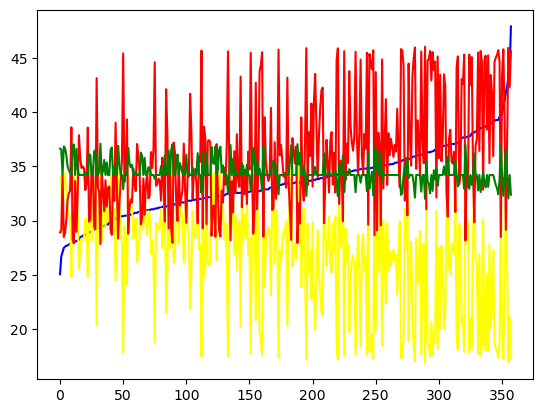

In [896]:
pre23 = [
    prediction_lst5[i][0][0] + prediction_lst5[i][0][1] for i in range(len(subwords))
]
pre56 = [
    prediction_lst5[i][0][2] + prediction_lst5[i][0][3] for i in range(len(subwords))
]
pairs = [
    (
        avgtry(fulltry_dist[i]),
        pre23[i],
        pre56[i],
        func3(pre23[i], pre56[i]),
    )
    for i in range(len(subwords))
]

pairs = np.asarray(sorted(pairs, key=lambda e: e[0])).T
plt.plot(np.arange(len(pairs[0])), pairs[0] * 8, c="blue")
plt.plot(np.arange(len(pairs[0])), pairs[1], c="yellow")
plt.plot(np.arange(len(pairs[0])), pairs[2], c="red")
plt.plot(np.arange(len(pairs[0])), pairs[3], c="green")
# plt.plot(np.arange(len(pairs[0])), pairs[4], c="black")

plt.show()

